In [1]:
import numpy
import math
from matplotlib import pyplot
%matplotlib inline
from scipy import integrate

### Definition of the Geometry

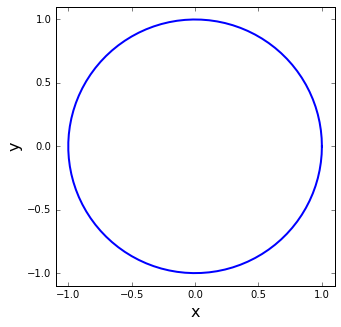

In [2]:
#defining cylinder
R = 1.0
theta = numpy.linspace(0,2*math.pi,100)      #discretizing angle in radians
x_cylinder,y_cylinder = R*numpy.cos(theta),R*numpy.sin(theta)

#plot the cylinder
size = 5
pyplot.figure(figsize=(size,size))
pyplot.xlabel('x',fontsize=16)
pyplot.ylabel('y',fontsize=16)
pyplot.xlim(-R-0.1,R+0.1)
pyplot.ylim(-R-0.1,R+0.1)
pyplot.plot(x_cylinder,y_cylinder,linewidth=2)

### Discretization into Panels

In [3]:
# creating class for panels
class Panel:
    """
    Contains information pertaining to a Panel
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        Sets the angles and calculates the length, center and angle of the panel with respect to the X-axis
        Initializes the strength of source-sheet, tangential velocity and pressure co-efficient to zero
        
        Parameters
        ----------
        xa: Float
            x-coordinate of the first end point
        
        ya: Float
            y-coordinate of the first end point
        
        xb: Float
            x-coordinate of the second end point
        
        yb: Float
            y-coordinate of the second end point
        """
        self.xa,self.ya = xa,ya
        self.xb,self.yb = xb,yb
        
        self.xc,self.yc = (xa+xb)/2,(ya+yb)/2;              # determining center of the panel
        self.length = math.sqrt((xb-xa)**2 + (yb-ya)**2)    # determining length of the panel
        
        #determining angle of the panel
        if xb-xa <=0.0:
            self.beta = math.acos((yb-ya)/self.length)
            #self.beta = math.atan((yb-ya)/(xb-xa))
        else:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
            #self.beta = math.pi + math.atan((yb-ya)/(xb-xa))
        
        self.sigma = 0.
        self.vt = 0.
        self.cp = 0.

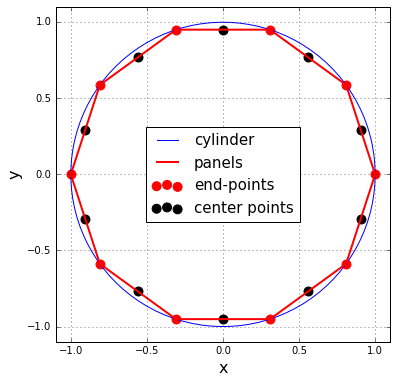

In [4]:
N_panels = 10
x_ends,y_ends = R*numpy.cos(numpy.linspace(0,2*math.pi,N_panels+1)),R*numpy.sin(numpy.linspace(0,2*math.pi,N_panels+1))

#defining the panels
panels = numpy.empty(N_panels,dtype = object)
for i in range (N_panels):
    panels[i] = Panel(x_ends[i],y_ends[i],x_ends[i+1],y_ends[i+1])

#plotting the figure with panels
size=6
pyplot.figure(figsize=(size,size))
pyplot.grid()
pyplot.xlabel('x',fontsize=16)
pyplot.ylabel('y',fontsize=16)
pyplot.xlim(-R-0.1,R+0.1)
pyplot.ylim(-R-0.1,R+0.1)

pyplot.plot(x_cylinder,y_cylinder,color = 'b',label='cylinder')
pyplot.plot(x_ends,y_ends,linewidth = 2,color = 'r',label='panels')
pyplot.scatter([p.xa for p in panels],[p.ya for p in panels],color='r',s=80,label='end-points')
pyplot.scatter([p.xc for p in panels],[p.yc for p in panels],color='k',s=80,label='center points')
pyplot.legend(loc='best',prop={'size':15})

### Flow Tangency Boundary Condition

In [5]:
def integrate_normal(p_i,p_j):
    """
    Evaluates the contribution of a panel at the center-point of another, in the normal direction.
    
    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel at the center point of the other.
    """
    # defining function for quad
    def integrand(s):
        return ( (+(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.cos(p_i.beta)
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.sin(p_i.beta))
                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, p_j.length)[0]
#    def integrand(s):
#        return (p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.cos(p_i.beta)\
#                + (p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.sin(p_i.beta)\
#                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2 + (p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2)
#    return integrate.quad(integrand,0.0,p_j.length)[0]

### Solving the system of equations

In [6]:
u_inf = 1.0                                          # adding a horizontal free stream
A = numpy.empty((N_panels,N_panels),dtype=float)
numpy.fill_diagonal(A,0.5)       # A=0.5 for i=j

for i,p_i in enumerate(panels):
    for j,p_j in enumerate(panels):
        if i!=j:
            A[i,j] = 0.5/math.pi*integrate_normal(p_i,p_j)

# computing the RHS of the equation
b = - u_inf * numpy.cos([p.beta for p in panels])

This system can be solved as a system of linear equations with the strength of each panel being unknown

In [7]:
sigma = numpy.linalg.solve(A,b)

# inputting the values in the class
for i,panel in enumerate(panels):
    panel.sigma = sigma[i]

### Pressure Coefficient on the Surface

In [8]:
def integrate_tangential(p_i,p_j):
    """
    Evaluates the contribution of a panel at the center-point of another, in the tangential direction.
    
    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel at the center point of the other.
    """
    def integrand(s):
        return ( (-(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.sin(p_i.beta)
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.cos(p_i.beta))
                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, p_j.length)[0]
    
#    def integrand(s):
#        return ((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*(-math.sin(p_i.beta))\
#                + (p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.cos(p_i.beta))\
#                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2 + (p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2)
#    
#    return integrate.quad(integrand,0.0,p_j.length)[0]

In [9]:
A1 = numpy.empty((N_panels,N_panels),dtype=float)
numpy.fill_diagonal(A1,0.0)       # A=0.0 for i=j

for i,p_i in enumerate(panels):
    for j,p_j in enumerate(panels):
        if i!=j:
            A1[i,j] = 0.5/math.pi*integrate_tangential(p_i,p_j)

# computing the RHS of the equation
b1 = - u_inf * numpy.sin([p.beta for p in panels])

#computing strength of each panel
#sigma1 = numpy.linalg.solve(A1,b1)

# computing the tangential velocity at each point
vt = numpy.dot(A1, sigma) + b1

for i,panel in enumerate(panels):
    panel.vt = vt[i]

In [10]:
# pressure coefficient
for panel in panels:
    panel.cp = 1.0 - (panel.vt/u_inf)**2

Comparing results with analytical solution

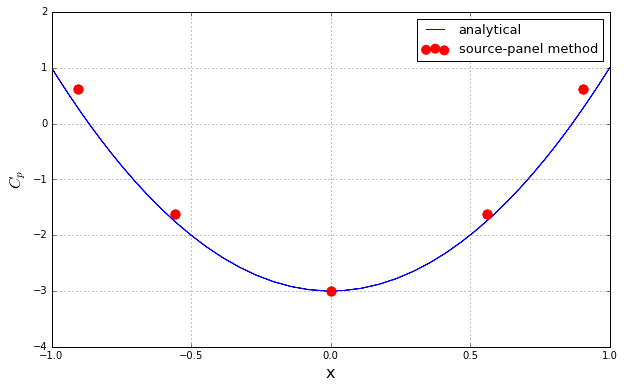

In [11]:
cp_analytical = 1 - 4*(y_cylinder/R)**2

#plotting
pyplot.figure(figsize=(10,6))
pyplot.grid(1)
pyplot.xlabel('x',fontsize=16)
pyplot.ylabel('$C_p$',fontsize=16)
pyplot.xlim(-R,R)
pyplot.ylim(-4.0,2.0)
pyplot.plot(x_cylinder,cp_analytical,color='b',label='analytical',zorder=1)
pyplot.scatter([p.xc for p in panels],[p.cp for p in panels],color='r',s=80,label='source-panel method',zorder=2)
pyplot.legend(loc='best',prop={'size':13})

### Challenge Task